In [14]:
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from datetime import datetime
import pandas as pd
from eo_flood_ops.thresholding_model import ThresholdingModel 
from eo_flood_ops.model_utils import GroundTruthMeasurement, LaplaceDepthSolverConfig, flood_extent_to_depth_solve
from eo_flood_ops.manifold_model import ManifoldModel

from eo_flood_ops.general_utils import tif_to_clipped_masked_array, tif_to_clipped_array, find_closest_valid, generate_timeseries_ds

class MyGroundTruthMeasurement(GroundTruthMeasurement):
  pass



In [2]:
aoi_name = "Samac"

images_dir = R"p:\11211461-010--eo-flood-ops\Sava\classified_events"

aoi_fn = os.path.join(
    R"p:\11211461-010--eo-flood-ops\Sava\AOI",
    f"AOI_{aoi_name}.geojson"
)
waterlevels_fn = R"p:\11211461-010--eo-flood-ops\Sava\water_levels\Sava_Bosna_gauges_H_20190101_20250430.csv"

dem_fn = R"p:\11211461-010--eo-flood-ops\Sava\DEMs\bosna_FABDEM.tif"

In [3]:
# Store image paths and water levels
image_water_levels = []

# Variable to check if any images were processed
datetime_str = None

# find the water level measurement closest to the image timestamp and store it the corresponding image path
for image_name in os.listdir(images_dir):
    if not image_name.endswith(".tif"):
        continue  # Skip non-TIF files
    datetime_str = image_name.split("_")[1].replace(".tif", "") 
    dt = datetime.strptime(datetime_str, "%Y%m%dT%H%M%S")
    dt = pd.Timestamp(dt)
    # Convert to GMT+1
    dt_gmt1 = dt + pd.Timedelta(hours=1)  

    df = pd.read_csv(waterlevels_fn, skiprows=[1])
    df.rename(columns={df.columns[0]: "datetime"}, inplace=True)
    df["datetime"] = pd.to_datetime(df["datetime"])
    station = aoi_name
    closest_time, value = find_closest_valid(df, dt_gmt1, station)
    
    if closest_time is not None:
        print(f"Image: {image_name}")  
        print("Closest valid timestamp:", closest_time)
        print(f"{station} value:", value)
        print("=" * 45)
        #image_path = os.path.join(images_dir, image_name)
        image_water_levels.append((image_name, value))
    else:
        print(f"No valid {station} values found in dataset.")
    
if datetime_str is None:
    raise ValueError("No images found in the specified directory.")

# Sort the list by water level (ascending) as required by the algorithm
image_water_levels.sort(key=lambda x: x[1])

Image: Bosna_20190204T164100.tif
Closest valid timestamp: 2019-02-04 18:00:00
Samac value: 8.14
Image: Bosna_20211107T045415.tif
Closest valid timestamp: 2021-11-07 06:00:00
Samac value: 5.22


In [4]:
GROUND_TRUTH = []
for image_name, water_level in image_water_levels:
    masked_array, transforms, crs = tif_to_clipped_masked_array(
        os.path.join(images_dir, image_name),
        aoi_fn,
    )
    GROUND_TRUTH.append(MyGroundTruthMeasurement(
        ground_truth=masked_array,
        gauge_measurement=water_level
    )
    )

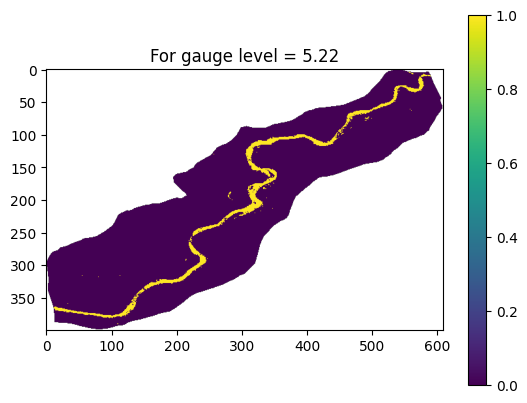

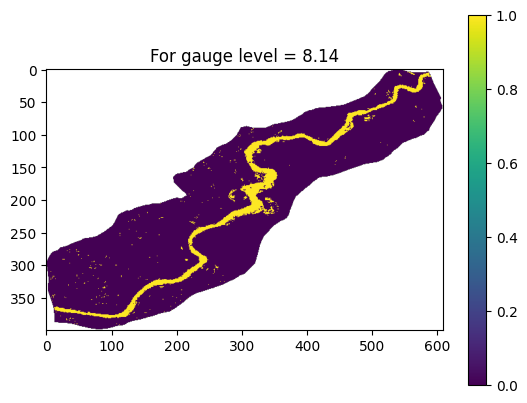

In [5]:
for gt in GROUND_TRUTH:
    plt.imshow(gt.ground_truth)
    plt.colorbar()
    plt.title(f'For gauge level = {gt.gauge_measurement}')
    plt.show()

In [6]:
# TRAINING THE MODEL
tm = ThresholdingModel()
# typical min ratio values to try
MIN_RATIOS = [0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20]

tm.train(
    minumum_ratios=MIN_RATIOS,
    ground_truth=GROUND_TRUTH
    )

C:\Users\tsiokano\git\EO-Flood-Ops\src\eo_flood_ops\model_utils.py:251: RuntimeWarning: divide by zero encountered in divide
  ratios = true_wets / false_wets
C:\Users\tsiokano\git\EO-Flood-Ops\src\eo_flood_ops\model_utils.py:251: RuntimeWarning: invalid value encountered in divide
  ratios = true_wets / false_wets


For min_ratio=0.1 we get f1=0.993717033819423
For min_ratio=0.3 we get f1=0.993717033819423
For min_ratio=0.5 we get f1=0.993717033819423
For min_ratio=1 we get f1=0.993717033819423
For min_ratio=2 we get f1=0.9936370777690496
For min_ratio=5 we get f1=0.9936370777690496
For min_ratio=10 we get f1=0.9936370777690496
For min_ratio=15 we get f1=0.9936370777690496
For min_ratio=20 we get f1=0.9936370777690496
chosen min_ratio 1


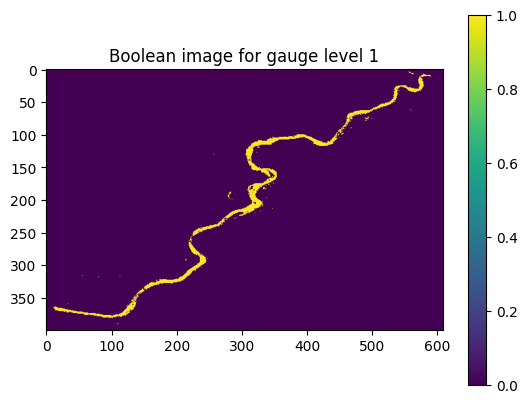

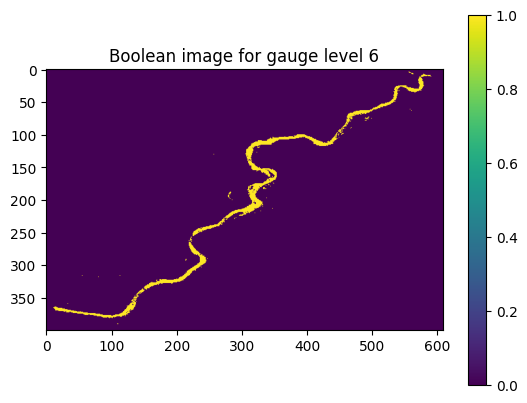

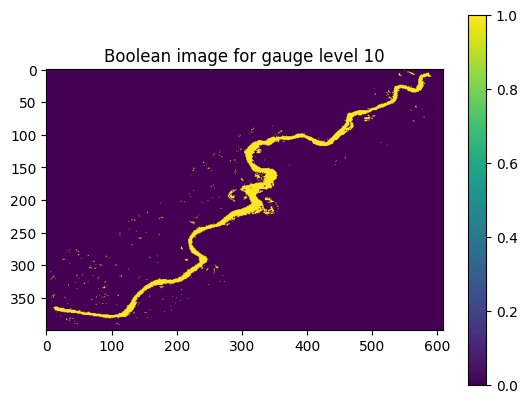

In [7]:
# example use of the model with infer (3 water levels)
for gauge_level in [1, 6, 10]:
    plt.title(f'Boolean image for gauge level {gauge_level}')
    plt.imshow(tm.infer(gauge_level))
    plt.colorbar()
    plt.show()

In [8]:
# example use of the function to generate a time series dataset
gauge_levels = [1, 6, 7.5, 3.2, 10]
timestamps = pd.date_range("2020-01-01", periods=len(gauge_levels), freq="7D")

ds = generate_timeseries_ds(gauge_levels, timestamps, tm, transforms, crs)
ds


<xarray.Dataset> Size: 5MB
Dimensions:      (lat: 400, lon: 609, time: 5)
Coordinates:
  * lat          (lat) float64 3kB 44.96 44.96 44.96 44.96 ... 45.07 45.07 45.07
  * lon          (lon) float64 5kB 18.3 18.3 18.3 18.3 ... 18.46 18.46 18.46
  * time         (time) datetime64[ns] 40B 2020-01-01 2020-01-08 ... 2020-01-29
    water_level  (time) float64 40B 1.0 6.0 7.5 3.2 10.0
Data variables:
    wet_dry      (time, lat, lon) float32 5MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    spatial_ref  int64 8B 0

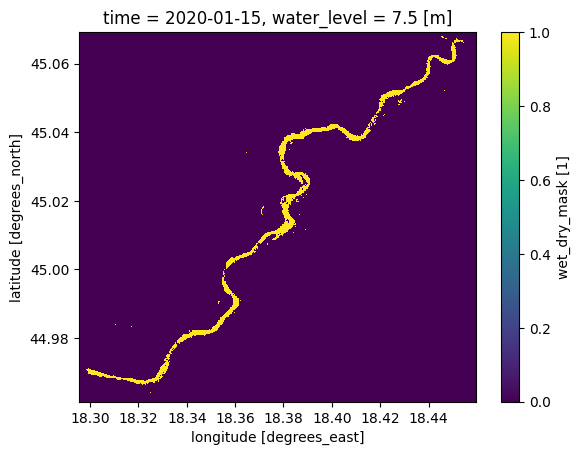

In [9]:
ds["wet_dry"].sel(time="2020-01-15").plot()

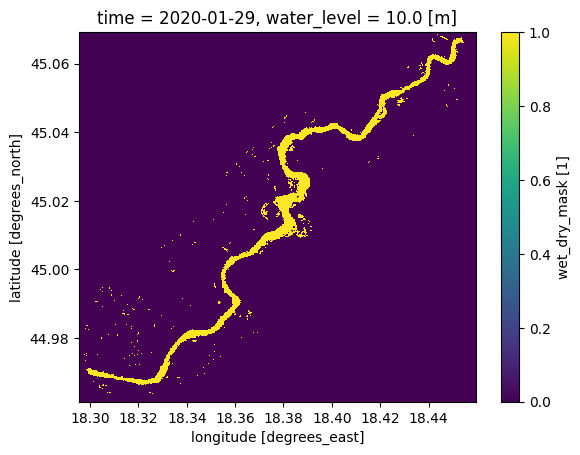

In [10]:
# example of plotting the wet/dry mask for the time with the highest water level
ds["wet_dry"].isel(time=ds["water_level"].argmax().item()).plot()

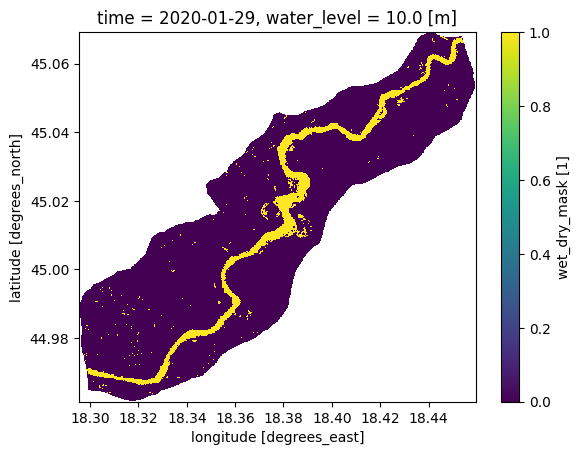

In [11]:
river_mask = gpd.read_file(aoi_fn)

ds_masked = ds.where(ds.raster.geometry_mask(river_mask, all_touched=False))
ds_masked["wet_dry"].isel(time=ds_masked["water_level"].argmax().item()).drop_vars("spatial_ref").plot()

### Manifold 

(400, 609)

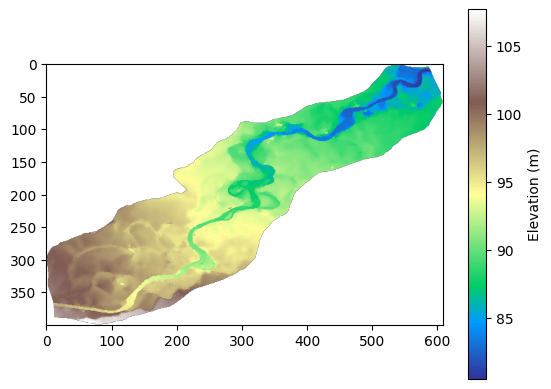

In [12]:
DEM, dem_transform, dem_crs = tif_to_clipped_array(dem_fn, aoi_fn)
plt.imshow(DEM, cmap='terrain')
plt.colorbar(label='Elevation (m)')
DEM.shape

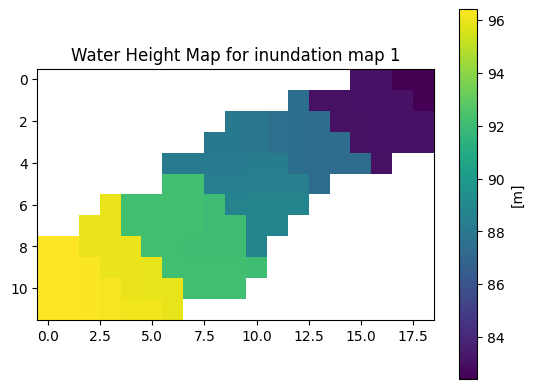

In [15]:
#@title Plot flood extent to depth output
height_raster = flood_extent_to_depth_solve(
    inundation_map=GROUND_TRUTH[0].ground_truth, 
    dem=DEM, 
    scale=30, 
    laplace_config=LaplaceDepthSolverConfig(
        down_scale_factor=32, 
        solve_iterations_factor=3.,
        force_coeff=0.1,
        drop_iterations=2,
        drop_coeff=0.1),
    force_tolerance=1, 
    force_local_region_width=5)

plt.title('Water Height Map for inundation map 1')
plt.imshow(height_raster)
plt.colorbar(label='[m]')
plt.show()

In [16]:
m = ManifoldModel(
    dem=DEM, 
    scale=30, 
    laplace_config=LaplaceDepthSolverConfig(
        down_scale_factor=32, 
        solve_iterations_factor=3.,
        force_coeff=0.9,
        drop_iterations=1,
        drop_coeff=0.00003),
    force_tolerance=1, 
    force_local_region_width=5,
    flood_agree_threshold=0)

m.train(minumum_ratios=[0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20],
        ground_truth=GROUND_TRUTH)

Training an inner thresholding model used for flood-fill.


C:\Users\tsiokano\git\EO-Flood-Ops\src\eo_flood_ops\model_utils.py:251: RuntimeWarning: divide by zero encountered in divide
  ratios = true_wets / false_wets
C:\Users\tsiokano\git\EO-Flood-Ops\src\eo_flood_ops\model_utils.py:251: RuntimeWarning: invalid value encountered in divide
  ratios = true_wets / false_wets


For min_ratio=0.1 we get f1=0.993717033819423
For min_ratio=0.3 we get f1=0.993717033819423
For min_ratio=0.5 we get f1=0.993717033819423
For min_ratio=1 we get f1=0.993717033819423
For min_ratio=2 we get f1=0.9936370777690496
For min_ratio=5 we get f1=0.9936370777690496
For min_ratio=10 we get f1=0.9936370777690496
For min_ratio=15 we get f1=0.9936370777690496
For min_ratio=20 we get f1=0.9936370777690496
chosen min_ratio 1
Running flood extent to depth on ground truth examples..
Running flood extent to depth algorithm for image at gauge_level 5.22
Running flood extent to depth algorithm for image at gauge_level 8.14


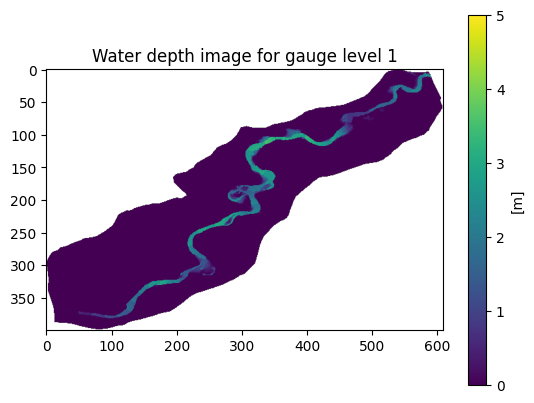

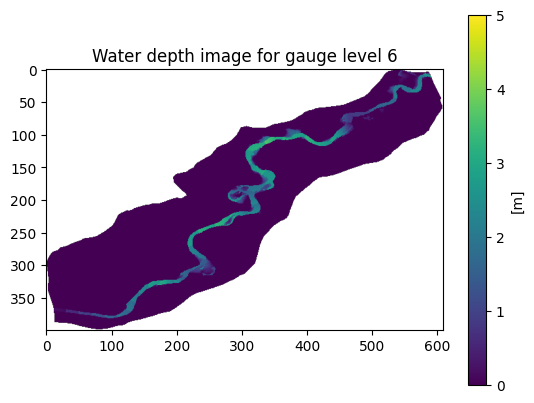

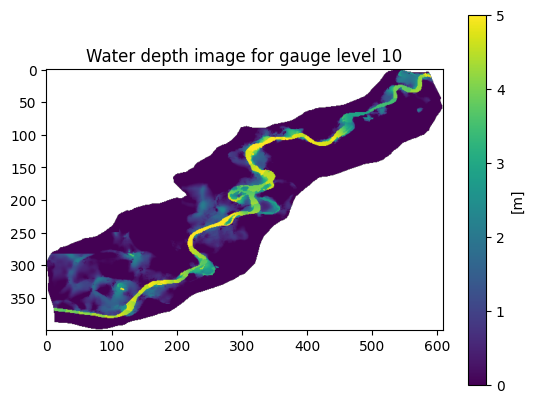

In [17]:
# Manifold interpolation example
for gauge_level in [1, 6, 10]:
    plt.title(f'Water depth image for gauge level {gauge_level}')
    plt.imshow(m.infer(gauge_level), vmin=0, vmax=5)
    plt.colorbar(label='[m]')
    plt.show()


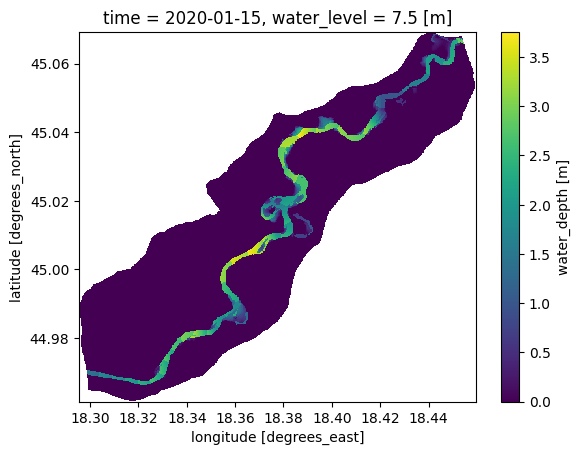

In [18]:
ds_man = generate_timeseries_ds(gauge_levels, timestamps, m, transforms, crs)
ds_man["water_depth"].sel(time="2020-01-15").plot();